# Homework 1 (Total Points: 250) <a class="anchor" id="top"></a>


**Submission instructions**:
- The cells with the `# YOUR CODE HERE` denote that these sections are graded and you need to add your implementation.
- For Part 1: You can use the `nltk`, `NumPy`, and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. For Part 2: `gensim` is allowed in addition to the imported libraries in the next code cell
- Please use Python 3.6.5 and `pip install -r requirements.txt` to avoid version issues.
- The notebook you submit has to have the student ids, separated by underscores (E.g., `12341234_12341234_12341234_hw1.ipynb`).
- This will be parsed by a regexp, **so please double check your filename**.
- Only one member of each group has to submit the file (**please do not compress the .ipynb file when you will submit it**) to canvas.
- **Make sure to check that your notebook runs before submission**. A quick way to do this is to restart the kernel and run all the cells.  
- Do not change the number of arugments in the given functions.
- **Please do not delete/add new cells**. Removing cells **will** lead to grade deduction. 
- Note, that you are not allowed to use Google Colab.


**Learning Goals**:
- [Part 1, Term-based matching](#part1) (165 points):
    - Learn how to load a dataset and process it.
    - Learn how to implement several standard IR methods (TF-IDF, BM25, QL) and understand their weaknesses & strengths.
    - Learn how to evaluate IR methods.
- [Part 2, Semantic-based matching](#part2) (85 points):
    - Learn how to implement vector-space retrieval methods (LSI, LDA).
    - Learn how to use LSI and LDA for re-ranking.

    
**Resources**: 
- **Part 1**: Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)
- **Part 2**: [LSI - Chapter 18](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) from [Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/) book and the [original LDA paper](https://jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:
# TODO: You can also use unlisted classes from these libraries or standard libraries (such as defaultdict, Counter, ...).

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from ipywidgets import widgets
from IPython.display import display, HTML
#from IPython.html import widgets
from collections import namedtuple

%matplotlib inline


# Part 1: Term-based Matching (165 points) <a class="anchor" id="part1"></a>

[Back to top](#top)

In the first part, we will learn the basics of IR from loading and preprocessing the material, to implementing some well known search algorithms, to evaluating the ranking performance of the implemented algorithms. We will be using the CACM dataset throughout the assignment. The CACM dataset is a collection of titles and abstracts from the journal CACM (Communication of the ACM).

Table of contents:
- [Section 1: Text Processing](#text_processing) (5 points)
- [Section 2: Indexing](#indexing) (10 points)
- [Section 3: Ranking](#ranking) (80 points)
- [Section 4: Evaluation](#evaluation) (40 points)
- [Section 5: Analysis](#analysis) (30 points)


---
## Section 1: Text Processing (5 points)<a class="anchor" id="text_processing"></a>

[Back to Part 1](#part1)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 
First, go through the implementation of the following functions:
- `read_cacm_docs`: Reads in the CACM documents.
- `read_queries`: Reads in the CACM queries.
- `load_stopwords`: Loads the stopwords.

The points of this section are earned for the following implementations:
- `tokenize` (3 points): Tokenizes the input text.
- `stem_token` (2 points): Stems the given token. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 


---
### 1.1 Read the CACM documents


The following cell downloads the dataset and unzips it to a local directory.

In [2]:
def download_dataset():
    folder_path = os.environ.get("IR1_DATA_PATH")
    if not folder_path:
        folder_path = "./datasets/"
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

---

You can see a brief description of each file in the dataset by looking at the README file:

In [3]:
##### Read the README file 
with open ("./datasets/README","r") as file:
    readme = file.read()
    print(readme)
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query



---
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
with open ("./datasets/cacm.all","r") as file:
    cacm_all = "".join(file.readlines()[:45])
    print(cacm_all)
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1



---

The following function reads the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document:

In [5]:
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (separated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    with open(os.path.join(root_folder, "cacm.all")) as reader:
        lines = reader.readlines()
    
    doc_id, title, abstract = None, None, None
    
    docs = []
    line_idx = 0
    while line_idx < len(lines):
        line = lines[line_idx]
        if line.startswith(".I"):
            if doc_id is not None:
                docs.append((doc_id, title, abstract))
                doc_id, title, abstract = None, None, None
            
            doc_id = line.split()[-1]
            line_idx += 1
        elif line.startswith(".T"):
            # start at next line
            line_idx += 1
            temp_lines = []
            # read till next '.'
            while not lines[line_idx].startswith("."):
                temp_lines.append(lines[line_idx].strip("\n"))
                line_idx += 1
            title = "\n".join(temp_lines).strip("\n")
        elif line.startswith(".W"):
            # start at next line
            line_idx += 1
            temp_lines = []
            # read till next '.'
            while not lines[line_idx].startswith("."):
                temp_lines.append(lines[line_idx].strip("\n"))
                line_idx += 1
            abstract = "\n".join(temp_lines).strip("\n")
        else:
            line_idx += 1
    
    docs.append((doc_id, title, abstract))
    
    p_docs = []
    for (did, t, a) in docs:
        if a is None:
            a = ""
        p_docs.append((did, t + "\n" + a))
    return p_docs


In [6]:
##### Function check
docs = read_cacm_docs()

assert isinstance(docs, list)
assert len(docs) == 3204, "There should be exactly 3204 documents"

unzipped_docs = list(zip(*docs))
assert np.sum(np.array(list(map(int,unzipped_docs[0])))) == 5134410

##### 

---
### 1.2 Read the CACM queries

Next, let us read the queries. They are formatted similarly:

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

The following function reads the `query.text` file:

In [8]:
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (query_id, query)
    """
    with open(os.path.join(root_folder, "query.text")) as reader:
        lines = reader.readlines()
    
    query_id, query = None, None
    
    queries = []
    line_idx = 0
    while line_idx < len(lines):
        line = lines[line_idx]
        if line.startswith(".I"):
            if query_id is not None:
                queries.append((query_id, query))
                query_id, query = None, None
    
            query_id = line.split()[-1]
            line_idx += 1
        elif line.startswith(".W"):
            # start at next line
            line_idx += 1
            temp_lines = []
            # read till next '.'
            while not lines[line_idx].startswith("."):
                temp_lines.append(lines[line_idx].strip("\n"))
                line_idx += 1
            query = "\n".join(temp_lines).strip("\n")
        else:
            line_idx += 1
    
    queries.append((query_id, query))
    return queries


In [9]:
##### Function check
queries = read_queries()

assert isinstance(queries, list)
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"

unzipped_queries = list(zip(*queries))
assert np.sum(np.array(list(map(int,unzipped_queries[0])))) == 2080

##### 

---
### 1.3 Read the stop words

We use the common words stored in `common_words`:

In [10]:
##### Read the stop words file 
!head ./datasets/common_words
##### Read the README file 

a
about
above
accordingly
across
after
afterwards
again
against
all


---

The following function reads the `common_words` file (For better coverage, we try to keep them in lowercase):

In [11]:
def load_stopwords(root_folder = "./datasets/"):
    """
        Loads the stopwords. The dataset is assumed to be in the folder "./datasets/" by default
        Output: A set of stopwords
    """
    with open(os.path.join(root_folder, "common_words")) as reader:
        lines = reader.readlines()
    stopwords = set([l.strip().lower() for l in lines])
    return stopwords


In [12]:
##### Function check
stopwords = load_stopwords()

assert isinstance(stopwords, set)
assert len(stopwords) == 428, "There should be exactly 428 stop words"

assert np.sum(np.array(list(map(len,stopwords)))) == 2234

##### 


---
### 1.4 Tokenization (3 points)

We can now write some basic text processing functions. 
A first step is to tokenize the text. 

**Note**: Use the  `WordPunctTokenizer` available in the `nltk` library:

In [13]:
# TODO: Implement this! (4 points)
def tokenize(text):
    """
        Tokenizes the input text. Use the WordPunctTokenizer
        Input: text - a string
        Output: a list of tokens
    """
    tk = nltk.tokenize.WordPunctTokenizer()
    return tk.tokenize(text)

In [14]:
##### Function check
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)

assert isinstance(tokens, list)
assert len(tokens) == 9

print(tokens)
# output: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---
### 1.5 Stemming (2 points)

Write a function to stem tokens. 
Again, you can use the nltk library for this:

In [15]:
# TODO: Implement this! (3 points)
def stem_token(token):
    """
        Stems the given token using the PorterStemmer from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    stemmer = nltk.stem.PorterStemmer()
    return stemmer.stem(token)

In [16]:
##### Function check

assert stem_token('owned') == 'own'
assert stem_token('itemization') == 'item'
#####

---
### 1.6 Summary

The following function puts it all together. Given an input string, this functions tokenizes and processes it according to the flags that you set.

In [17]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

---

Let's create two sets of preprocessed documents.
We can process the documents and queries according to these two configurations:

In [18]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text, stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 

####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####

--- 

## Section 2: Indexing (10 points)<a class="anchor" id="indexing"></a>

[Back to Part 1](#part1)



A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### 2.1 Term Frequency-index (10 points)
In this assignment, we will be using an index created in memory since our dataset is tiny. To get started, build a simple index that maps each `token` to a list of `(doc_id, count)` where `count` is the count of the `token` in `doc_id`.
For consistency, build this index using a python dictionary.
    
Now, implement a function to build an index:

In [19]:
# TODO: Implement this! (10 points)
from collections import defaultdict
def build_tf_index(documents):
    """
        Build an inverted index (with counts). The output is a dictionary which takes in a token
        and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
        Input: a list of documents - (doc_id, tokens) 
        Output: An inverted index implemented within a pyhton dictionary: [token] -> [(doc_id, token_count)]
    """
    # YOUR CODE HERE
    index = defaultdict(list)
    for (doc_id, tokens) in documents:
        doc_id = int(doc_id)
        seen_tks = {}
        for tk in tokens:
            new_tk = tk not in index
            if new_tk:
                index[tk] = []
            if tk not in seen_tks:
                index[tk].append([doc_id, 1])
                seen_tks[tk] = True
            else:
                index[tk][-1][1] += 1
    return index

---
Now we can build indexed documents and preprocess the queries based on the two configurations:

In [20]:
#### Indexed documents based on the two configs

# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the tf_index of the corresponding config
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

####
#### Preprocessed query based on the two configs

# This function preprocesses the text given the index set, according to the specified config
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)

#### 

In [21]:
##### Function check

assert isinstance(tf_index_1, dict)

assert isinstance(tf_index_1['computer'], list)
print('sample tf index for computer:', tf_index_1['computer'][:10])

assert isinstance(tf_index_1['examples'], list)
print('sample tf index for examples:', tf_index_1['examples'][:10])
#### 

sample tf index for computer: [[4, 1], [7, 1], [10, 1], [13, 1], [19, 1], [22, 1], [23, 1], [37, 1], [40, 3], [41, 1]]
sample tf index for examples: [[111, 1], [320, 1], [644, 1], [691, 1], [727, 1], [848, 1], [892, 1], [893, 1], [1049, 1], [1051, 1]]


In [22]:
##### Function check

assert isinstance(tf_index_2, dict)

assert isinstance(tf_index_2['computer'], list)
print('sample tf index for computer:', tf_index_1['computer'][:10])

assert isinstance(tf_index_2['examples'], list)
print('sample tf index for examples:', tf_index_2['examples'][:10])
#### 

sample tf index for computer: [[4, 1], [7, 1], [10, 1], [13, 1], [19, 1], [22, 1], [23, 1], [37, 1], [40, 3], [41, 1]]
sample tf index for examples: []



---
## Section 3: Ranking  (80 points) <a class="anchor" id="ranking"></a>

[Back to Part 1](#part1)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- [Section 3.1: Bag of Words](#bow) (10 points)
- [Section 3.2: TF-IDF](#tfidf) (15 points)
- [Section 3.3: Query Likelihood Model](#qlm) (35 points)
- [Section 3.4: BM25](#bm25) (20 points)

*All search functions should be able to handle multiple words queries.*

**Scoring policy:**
Your implementations in this section are scored based on the expected performance of your ranking functions.
You will get a full mark if your implementation meets the expected performance (measured by some evaluation metric).
Otherwise, you may get partial credit.
For example, if your *Bag of words* ranking function has 60% of expected performance, you will get 6 out of 10.

--- 

### Section 3.1: Bag of Words (10 points)<a class="anchor" id="bow"></a>

Probably the simplest IR model is the Bag of Words (BOW) model.
Implement a function that scores and ranks all the documents against a query using this model.   

- For consistency, you should use the count of the token and **not** the binary indicator.
- Use `float` type for the scores (even though the scores are integers in this case).
- No normalization of the scores is necessary, as the ordering is what we are interested in.
- If two documents have the same score, they can have any ordering: you are not required to disambiguate.


In [23]:
# TODO: Implement this! (10 points)

def dict_to_arr(d, descending=True):
    arr = []
    for (k, _) in doc_repr_1:
         arr.append([k, 0. if int(k) not in d else d[int(k)]])
    return sorted(arr, key=lambda x: x[1], reverse=descending)
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note: You have to use the `get_index` function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query. 
    """
    index = get_index(index_set)
    processed_query = preprocess_query(query, index_set)
    scores = {}
    for q in processed_query:
        if q not in index: continue
        for (doc_id, freq) in index[q]:
            if doc_id not in scores:
                scores[doc_id] = float(freq)
            else:
                scores[doc_id] += freq
    return dict_to_arr(scores)

In [24]:
#### Function check

test_bow = bow_search("how to implement bag of words search", index_set=1)[:5]
assert isinstance(test_bow, list)
assert len(test_bow[0]) == 2
assert isinstance(test_bow[0][0], str)
assert isinstance(test_bow[0][1], float)

#### 

In [25]:

docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow_2 = bow_search("computer search word", index_set=2)[:5]
print(f"BOW Results:")
print_results(test_bow_2)


BOW Results:
Rank 0(1.3e+01): On Computing The Fast Fourier Transform\nCooley an...
Rank 1(1.2e+01): Variable Length Tree Structures Having Minimum Ave...
Rank 2(1.1e+01): A Modular Computer Sharing System\nAn alternative ...
Rank 3(1e+01): PEEKABIT, Computer Offspring of Punched\nCard PEEK...
Rank 4(9.0): Computer Simulation-Discussion of the\nTechnique a...


In [26]:

test_bow_1 = bow_search("computer search word", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow_1)


BOW Results:
Rank 0(9.0): CURRICULUM 68 -- Recommendations for Academic\nPro...
Rank 1(9.0): Variable Length Tree Structures Having Minimum Ave...
Rank 2(7.0): Computer Formulation of the Equations of Motion Us...
Rank 3(7.0): The Effects of Multiplexing on a Computer-Communic...
Rank 4(6.0): Optimizing Bit-time Computer Simulation\nA major c...


In [27]:
print('top-5 docs for index1:', list(zip(*test_bow_1[:5]))[0])
print('top-5 docs for index2:', list(zip(*test_bow_2[:5]))[0])


top-5 docs for index1: ('1771', '1936', '1543', '2535', '678')
top-5 docs for index2: ('1525', '1936', '1844', '1700', '1366')



---

### Section 3.2: TF-IDF (15 points) <a class="anchor" id="tfidf"></a>

Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

#### 3.2.1 Document frequency (5 points)
Compute the document frequencies of all tokens in the collection. 
Your code should return a dictionary with tokens as its keys and the number of documents containing the token as values.
For consistency, the values should have `int` type.

In [28]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency (int)}
    """
    # YOUR CODE HERE
    df = {}
    for doc in documents:
        seen_tks = {}
        for tk in doc:
            if tk not in df:
                df[tk] = 0
            df[tk] += not tk in seen_tks
            seen_tks[tk] = True
    return df

In [29]:
#### Compute df based on the two configs

# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]
####

In [30]:
#### Function check

print(df_1['computer'])
print(df_2['computer'])
####

597
11


---
#### 3.2.2 TF-IDF search (10 points)
Next, implement a function that computes a tf-idf score, given a query.
Use the following formulas for TF and IDF:

$$ TF=\log (1 + f_{d,t}) $$

$$ IDF=\log (\frac{N}{n_t})$$

where $f_{d,t}$ is the frequency of token $t$ in document $d$, $N$ is the number of total documents and $n_t$ is the number of documents containing token $t$.

**Note:** your implementation will be auto-graded assuming you have used the above formulas.


In [31]:
# TODO: Implement this! (10 points)
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    df = get_df(index_set)
    processed_query = preprocess_query(query, index_set)
    
    N = len(docs)
    
    scores = {}
    for q in processed_query:
        if q not in index: continue
        for (doc_id, freq) in index[q]:
            tf = np.log(1 + freq)
            idf = np.log(N/df[q])
            if doc_id not in scores:
                scores[doc_id] = 0
            scores[doc_id] += tf*idf #question: correct to add tfidf score of each word?
  
    return dict_to_arr(scores)

In [32]:

#### Function check
test_tfidf = tfidf_search("how to implement tf idf search", index_set=1)[:5]
assert isinstance(test_tfidf, list)
assert len(test_tfidf[0]) == 2
assert isinstance(test_tfidf[0][0], str)
assert isinstance(test_tfidf[0][1], float)

####

In [33]:

test_tfidf_2 = tfidf_search("computer word search", index_set=2)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf_2)


TFIDF Results:
Rank 0(1.3e+01): PEEKABIT, Computer Offspring of Punched\nCard PEEK...
Rank 1(9.8): Variable Length Tree Structures Having Minimum Ave...
Rank 2(8.2): A Stochastic Approach to the Grammatical Coding of...
Rank 3(8.1): Full Table Quadratic Searching for Scatter Storage...
Rank 4(7.6): Use of Tree Structures for Processing Files\nIn da...


In [34]:

test_tfidf_1 = tfidf_search("computer word search", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf_1)


TFIDF Results:
Rank 0(9.4): Variable Length Tree Structures Having Minimum Ave...
Rank 1(7.4): On the Feasibility of Voice Input to\nan On-line C...
Rank 2(7.3): Median Split Trees: A Fast Lookup Technique for Fr...
Rank 3(7.0): Execution Time Requirements for Encipherment Progr...
Rank 4(7.0): Storage and Search Properties of a Tree-Organized ...


In [35]:

print('top-5 docs for index1 with BOW search:', list(zip(*test_bow_1[:5]))[0])
print('top-5 docs for index2 with BOW search:', list(zip(*test_bow_2[:5]))[0])
print('top-5 docs for index1 with TF-IDF search:', list(zip(*test_tfidf_1[:5]))[0])
print('top-5 docs for index2 with TF-IDF search:', list(zip(*test_tfidf_2[:5]))[0])



top-5 docs for index1 with BOW search: ('1771', '1936', '1543', '2535', '678')
top-5 docs for index2 with BOW search: ('1525', '1936', '1844', '1700', '1366')
top-5 docs for index1 with TF-IDF search: ('1936', '2054', '3041', '2620', '944')
top-5 docs for index2 with TF-IDF search: ('1700', '1936', '1235', '2018', '849')


--- 

### Section 3.3: Query Likelihood Model (35 points) <a class="anchor" id="qlm"></a>

In this section, you will implement a simple query likelihood model. 


#### 3.3.1 Naive QL (15 points)

First, let us implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 



In [36]:
#### Document length for normalization

def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [37]:
# TODO: Implement this! (15 points)
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    scores = {}
    for q in processed_query:
        if q not in index: continue
        for (doc_id, freq) in index[q]:
            if doc_id not in scores:
                scores[doc_id] = 1
            scores[doc_id] *= freq/doc_lengths[str(doc_id)]
    return dict_to_arr(scores)

In [38]:
#### Function check
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"Naive QL Results:")
print_results(test_naiveql)
####

Naive QL Results:
Rank 0(0.2): A Report Writer For COBOL...
Rank 1(0.2): A CRT Report Generating System...
Rank 2(0.17): Preliminary Report-International Algebraic Languag...
Rank 3(0.17): Supplement to the ALGOL 60 Report...
Rank 4(0.14): ALGOL Sub-Committee Report - Extensions...


In [39]:
#### Please do not change this. This cell is used for grading.

In [40]:
#### Please do not change this. This cell is used for grading.

In [41]:
#### Please do not change this. This cell is used for grading.

In [42]:
#### Please do not change this. This cell is used for grading.

---
#### 3.3.2 QL (20 points)
Now, let's implement a QL model that handles the issues with the naive version. In particular, you will implement a QL model with Jelinek-Mercer Smoothing. That means an interpolated score is computed per word - one term is the same as the previous naive version, and the second term comes from a unigram language model. In addition, you should accumulate the scores by summing the **log** (smoothed) probability which leads to better numerical stability.

In [43]:
# TODO: Implement this! (20 points)

# YOUR CODE HERE
# raise NotImplementedError()

def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a QL model 
        with Jelinek-Mercer Smoothing (set smoothing=0.1). 
        
        
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        
        
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    scores = {}
    N = sum(doc_lengths.values())        
    
    for q in processed_query:
        seen = {int(key): False for key in doc_lengths.keys()}
        n = sum([x[1] for x in index[q]])
        if q in index:
            for (doc_id, freq) in index[q]:
                D = doc_lengths[str(doc_id)]
                if doc_id not in scores:
                    scores[doc_id] = 0
                scores[doc_id] += np.log(0.9*freq/D + 0.1*n/N)
                seen[doc_id] = True
        for k in seen.keys():
            if not seen[k]:
                if k not in scores:
                    scores[k] = 0
                scores[k] += np.log(1e-20)
    return dict_to_arr(scores)

In [44]:
#### Function check
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(-1.7): A Report Writer For COBOL...
Rank 1(-1.7): A CRT Report Generating System...
Rank 2(-1.9): Preliminary Report-International Algebraic Languag...
Rank 3(-1.9): Supplement to the ALGOL 60 Report...
Rank 4(-2.1): ALGOL Sub-Committee Report - Extensions...

Rank 0(-1.7e+01): A Report Writer For COBOL...
Rank 1(-1.7e+01): A CRT Report Generating System...
Rank 2(-1.9e+01): Preliminary Report-International Algebraic Languag...
Rank 3(-1.9e+01): Supplement to the ALGOL 60 Report...
Rank 4(-2.1e+01): ALGOL Sub-Committee Report - Extensions...


In [45]:
#### Please do not change this. This cell is used for grading.

In [46]:
#### Please do not change this. This cell is used for grading.

In [47]:
#### Please do not change this. This cell is used for grading.

In [48]:
#### Please do not change this. This cell is used for grading.

--- 

### Section 3.4: BM25 (20 points) <a class="anchor" id="bm25"></a>

In this section, we will implement the BM25 scoring function. 


In [49]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. Use k_1 = 1.5 and b = 0.75
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    k_1 = 1.5
    b = 0.75
    index = get_index(index_set)
    df = get_df(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    scores = {}
    vals = doc_lengths.values()
    N = len(vals)
    dl_avg = sum(vals)/len(vals)
    for q in processed_query:
        if q not in index: continue
        for (doc_id, freq) in index[q]:
            if doc_id not in scores:
                scores[doc_id] = 0
            scores[doc_id] += np.log(N/df[q])*(k_1+1)*freq/(k_1*(1-b + b*doc_lengths[str(doc_id)]/dl_avg)+freq)
    return dict_to_arr(scores)

In [50]:
#### Function check
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.7): A Report Writer For COBOL...
Rank 1(6.7): A CRT Report Generating System...
Rank 2(6.6): Preliminary Report-International Algebraic Languag...
Rank 3(6.6): Supplement to the ALGOL 60 Report...
Rank 4(6.5): ALGOL Sub-Committee Report - Extensions...


In [51]:
#### Please do not change this. This cell is used for grading.

In [52]:
#### Please do not change this. This cell is used for grading.

In [53]:
#### Please do not change this. This cell is used for grading.

In [54]:
#### Please do not change this. This cell is used for grading.


---

### 3.5. Test Your Functions

The widget below allows you to play with the search functions you've written so far. Use this to test your search functions and ensure that they work as expected.

In [55]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

In [56]:
# TODO: Set this to the function you want to test!
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

---

## Section 4: Evaluation (40 points) <a class="anchor" id="evaluation"></a>

[Back to Part 1](#part1)

In order to analyze the effectiveness of retrieval algorithms, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision (7 points)
2. Recall (7 points)
3. Mean Average Precision (13 points)
4. Expected Reciprocal Rank (13 points)

---
### 4.1 Read relevance labels

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [57]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


---

The first column is the query_id and the second column is the document_id. We can safely ignore the 3rd and 4th columns.

In [58]:
def read_qrels():
    obj = {}
    table = np.loadtxt('./datasets/qrels.text', dtype=int)[:, 0:2]
    for (qid, did) in table:
        qid = str(qid)
        if qid not in obj:
            obj[qid] = [did]
        else:
            obj[qid].append(did)
    return obj

In [59]:
#### Function check
qrels = read_qrels()

assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"

assert np.min(np.array([len(j) for j in qrels.values()])) == 1
assert np.max(np.array([len(j) for j in qrels.values()])) == 51

####

---
**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


---
### 4.2 Precision (7 points)
Implement the `precision@k` metric:

In [60]:
# TODO: Implement this! (7 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    if k > len(results):
        k = len(results)
    res = set([x[0] for x in results[0:k]])
    rel = set(relevant_docs)
    return sum([int(r) in rel for r in res])/k

In [61]:

#### Function check
qid = queries[0][0]
qtext = queries[0][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
precision = precision_k(results, qrels[qid], 10)
print(f'precision@10 = {precision}')
####

query: What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
precision@10 = 0.2


---
### 4.3 Recall (7 points)
Implement the `recall@k` metric:

In [62]:
# TODO: Implement this! (7 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    res = set([x[0] for x in results[0:k]])
    rel = set(relevant_docs)
    return sum([int(r) in rel for r in res])/len(relevant_docs)

In [63]:
#### Function check
qid = queries[10][0]
qtext = queries[10][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
recall = recall_k(results, qrels[qid], 10)
print(f'recall@10 = {recall}')
####

query: SETL, Very High Level Languages
recall@10 = 0.3157894736842105


---
### 4.4 Mean Average Precision (13 points)
Implement the `map` metric:

In [64]:
# TODO: Implement this! (12 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    N_relevant = len(relevant_docs)
    relevant = []
    numerator = 0 
    for i, result in enumerate(results):
        if int(result[0]) in relevant_docs:
            relevant.append(i)
    numerator = np.sum([precision_k(results, relevant_docs, i + 1) for i in relevant])
    AP = numerator / N_relevant
    return  AP

In [65]:
#### Function check
qid = queries[20][0]
qtext = queries[20][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
mean_ap = average_precision(results, qrels[qid])
print(f'MAP = {mean_ap}')
####

query: computational complexity, intractability, class-complete reductions,
algorithms and efficiency
MAP = 0.1724040411055945


---
### 4.5 Expected Reciprocal Rank (13 points)
Implement the `err` metric:

In [66]:
# TODO: Implement this! (12 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    p = 1
    err = 0
    n = len(results)
    rel = set(relevant_docs)
    for i in range(len(results)):
        R = (int(results[i][0]) in rel)/2
        err += p*R/(i+1)
        p *= 1-R
    return err

In [67]:
#### Function check
qid = queries[30][0]
qtext = queries[30][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
ERR = err(results, qrels[qid])
print(f'ERR = {ERR}')
####

query: I'd like to find articles describing the use of singular value decomposition
in digital image processing.  Applications include finding approximations
to the original image and restoring images that are subject to noise. An
article on the subject is H.C. Andrews and C.L. Patterson "Outer product
expansions and their uses in digital image processing", American Mathematical
Monthly, vol. 82.
ERR = 0.625


---
### 4.6 Evaluate Search Functions

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [68]:
#### metrics@k functions

recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)


list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [69]:
#### Evaluate a search function

list_of_search_fns = [
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search),
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search)
]

def evaluate_search_fn(search_fn, metric_fns, index_set=None):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = {}
    for metric, metric_fn in metric_fns:
        metrics[metric] = np.zeros(len(qrels), dtype=np.float32)
    
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        if index_set:
            results = search_fn(query, index_set)
        else:
            results = search_fn(query)
        
        for metric, metric_fn in metric_fns:
            metrics[metric][i] = metric_fn(results, relevant_docs)

    
    
    final_dict = {}
    for metric, metric_vals in metrics.items():
        final_dict[metric] = metric_vals.mean()
    
    return final_dict
####

## Section 5: Analysis (30 points) <a class="anchor" id="analysis"></a>

[Back to Part 1](#part1)

In the final section of Part1, we will compare the different term-based IR algorithms and different preprocessing configurations and analyze their advantages and disadvantages.

### Section 5.1: Plot (20 points)

First, gather the results. The results should consider the index set, the different search functions and different metrics. Plot the results in bar charts, per metric, with clear labels.

**Rubric:**
- Each Metric is plotted: 7 points
- Each Method is plotted: 7 points
- Clear titles, x label, y labels and legends (if applicable): 6 points

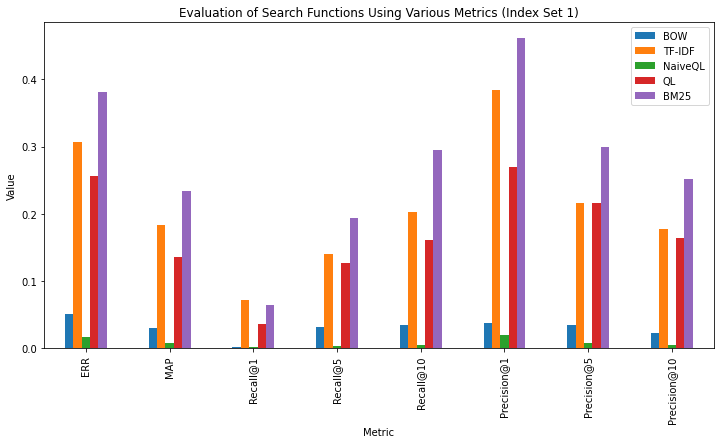

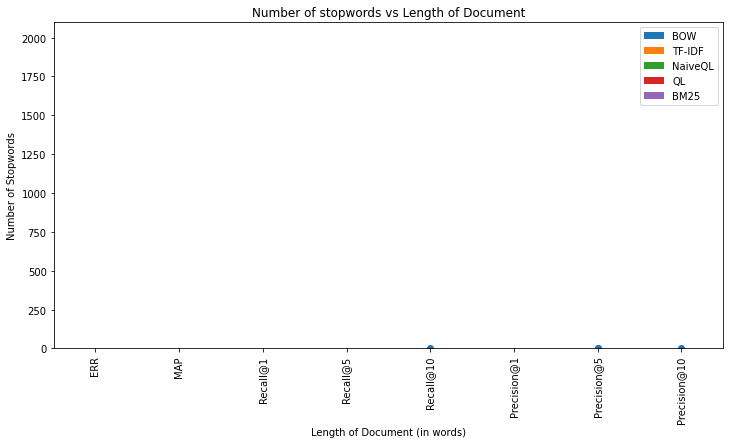

In [70]:
import pandas as pd
def plot_results(search_fns, title, include_index):
    results = []
    for i in [1,2] if include_index else [None]:
        r = []
        for (s_name, s_fn) in search_fns:
            r.append((s_name, evaluate_search_fn(s_fn, list_of_metrics, index_set=i)))
        results.append(r)

    index = [x[0] for x in results[0]]
    data = {}

    for r in range(2 if include_index else 1):
        for k in results[0][0][1].keys():
            data[k] = [x[1][k] for x in results[r]]
        df = pd.DataFrame(data, index)
        if include_index:
            df.T.plot.bar(figsize=(12,6), title=f'{title} (Index Set {r+1})', xlabel = "Metric", ylabel="Value")
        else:
            df.T.plot.bar(figsize=(12,6), title=title, xlabel = "Metric", ylabel="Value")
            
plot_results(list_of_search_fns, "Evaluation of Search Functions Using Various Metrics", True)

x = []
y = []
for (doc_id, document) in docs:
    n = 0
    for tk in document:
        if tk in stopwords:
            n += 1
    y.append(n)
    x.append(len(document))
plt.scatter(x,y)
plt.title("Number of stopwords vs Length of Document")
plt.xlabel("Length of Document (in words)")
plt.ylabel("Number of Stopwords")
plt.show()

---
### Section 5.2: Summary (10 points)
Write a summary of what you observe in the results.
Your summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      

The results across metrics and indices were as expected. We begin by explaining the trends across different methods and their respective performance, then compare the results across the 2 indices.

Firstly, we observe that the metric used does not influence the order in which we rank the performance of each search function. The results for recall@k improve with increasing k and decrease precision@k. This is in line with our expectation per the definition of these functions. 

The plot in 5.1 demonstrates that the TF-IDF, BM25, and QL search functions show similar performance, whereas the BOW model performs significantly worse. This is because the BOW model, unlike the others, does not utilize any information about the length of a document. Intuitively, if two documents mention a term of interest the same number of times, the shorter document is likely to be more focused on that term and, therefore, more relevant to the search.

The Naive-QL approach is the poorest performer of all the search functions. Each document's relevance score is a product of floats that are between zero and one, which makes this method vulnerable to underflow. This makes it likely that each document obtains an equal relevance score -- zero.

The difference in the performance between index set 1 and set 2 can be attributed to removing stopwords in the documents. The plot above shows the number of stopwords in a document is directly proportional to the length of the document. In the case where stopwords are not removed, if a query contains stopwords, longer documents are likely to be favoured rather than documents whose content are more closely related to the query. As a result, search accuracy suffers. This can be seen in the plot in section 5.1, where all search functions improve when stopwords are removed.

---
---
# Part 2: Semantic-based Matching (85 points) <a class="anchor" id="part2"></a>

[Back to top](#top)

We will now experiment with methods that go beyond lexical methods like TF-IDF, which operate at the word level and are high dimensional and sparse, and look at methods which constructs low dimensional dense representations of queries and documents. 

Since these low-dimensional methods have a higher time complexity, they are typically used in conjunction with methods like BM-25. That is, instead of searching through potentially million documents to find matches using low dimensional vectors, a list of K documents are retrieved using BM25, and then **re-ranked** using the other method. This is the method that is going to be applied in the following exercises. 

LSI/LDA takes documents that are similar on a semantic level - for instance, if they are describing the same topic - and projects them into nearby vectors, despite having low lexical overlap.

In this assignment, you will use `gensim` to create LSI/LDA models and use them in re-ranking. 

**Note**: The following exercises only uses `doc_repr_2` and `config_2`

Table of contents:
- [Section 6: LSI](#lsi) (15 points)
- [Section 7: LDA](#lda) (10 points)
- [Section 8: Word2Vec/Doc2Vec](#2vec) (20 points)
- [Section 8: Re-ranking](#reranking) (10 points)
- [Section 9: Re-ranking Evaluation](#reranking_eval) (30 points)

---
## Section 6: Latent Semantic Indexing (LSI) (15 points) <a class="anchor" id="lsi"></a>

[Back to Part 2](#part2)

LSI is one of the methods to embed the queries and documents into vectors. It is based on a method similar to Principal Component Analysis (PCA) for obtaining a dense concept matrix out of the sparse term-document matrix.

See [wikipedia](https://en.wikipedia.org/wiki/Latent_semantic_analysis), particularly [#Mathematics_of_LSI](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Mathematics_of_LSI).

In [71]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import downloader as g_downloader
# gensim uses logging, so set it up 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

---
### Section 6.1: Cosine Similarity (5 points)<a class="anchor" id="cosing_sim"></a>
Before we begin, let us first define our method of similarity for the LSI model, the cosine similarity:

$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

Since we are using gensim, the types of vectors returned by their classes are of the form defined below (they are not just simple vectors):

In [72]:
# 1, 2, 3 are either latent dimensions (LSI), or topics (LDA)
# The second value in each tuple is a number (LSI) or a probability (LDA)  
example_vec_1 = [(1, 0.2), (2, 0.3), (3, 0.4)]
example_vec_2 = [(1, 0.2), (2, 0.7), (3, 0.4)]

---
**Implementation (2+3 points):**
Now, implement the `dot product` operation on these types of vectors and using this operator, implement the `cosine similarity` (don't forget: two functions to implement!):

In [73]:
def dot(vec_1,vec_2): 
    """
        vec_1 and vec_2 are of the form: [(int, float), (int, float), ...]
        Return the dot product of two such vectors, computed only on the floats
        You can assume that the lengths of the vectors are the same, and the dimensions are aligned 
            i.e you won't get: vec_1 = [(1, 0.2)] ; vec_2 = [(2, 0.3)] 
                                (dimensions are unaligned and lengths are different)
    """
    return sum([x[1]*y[1] for (x,y) in zip(vec_1, vec_2)])


# TODO: Implement this! (3 points)
def cosine_sim(vec_1, vec_2):
    d = dot(vec_1,vec_2)
    x = sum([x[1]**2 for x in vec_1])
    y = sum([y[1]**2 for y in vec_2])
    if x*y == 0: return 0
    else: return d/np.sqrt(x)/np.sqrt(y)

In [74]:
##### Function check
print(f'vectors: {(example_vec_1,example_vec_2)}')
print(f'dot product = {dot(example_vec_1,example_vec_2)}')
print(f'cosine similarity = {cosine_sim(example_vec_1,example_vec_2)}')
##### 

vectors: ([(1, 0.2), (2, 0.3), (3, 0.4)], [(1, 0.2), (2, 0.7), (3, 0.4)])
dot product = 0.41000000000000003
cosine similarity = 0.9165587597202864


In [75]:
#### Please do not change this. This cell is used for grading.

---
### Section 6.2: LSI Retrieval (10 points)<a class="anchor" id="lsi_retrieval"></a>
LSI retrieval is simply ranking the documents based on their cosine similarity to the query vector.
First, let's write a parent class for vector-based retrieval models:

In [76]:
class VectorSpaceRetrievalModel:
    """
        Parent class for Dense Vector Retrieval models
    """
    def __init__(self, doc_repr):
        """
            document_collection: 
                [
                    (doc_id_1, [token 1, token 2, ...]), 
                    (doc_id_2, [token 1, token 2, ....]) 
                    ...
                ]

        """
        self.doc_repr = doc_repr
        self.documents = [_[1] for _ in self.doc_repr]
        
        # construct a dictionary
        self.dictionary = Dictionary(self.documents)
        # Filter out words that occur less than 20 documents, or more than 50% of the documents.
        self.dictionary.filter_extremes(no_below=10)
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.documents]
    
        # Make a index to word dictionary.
        temp = self.dictionary[0]  # This is only to "load" the dictionary.
        self.id2word = self.dictionary.id2token
        
        # this is set by the train_model function
        self.model = None
        
        
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        vectors = {}
        for (doc_id, _), cc in zip(self.doc_repr, self.corpus):
            vectors[doc_id] = self.model[cc]
        return vectors

    def vectorize_query(self, query):
        # Note the use of config_2 here!
        query = process_text(query, **config_2)
        query_vector = self.dictionary.doc2bow(query)
        return self.model[query_vector]
    
    def train_model(self):
        """
            Trains a model and sets the 'self.model' variable. 
            Make sure to use the variables created in the __init__ method.
            e.g the variables which may be useful: {corpus, dictionary, id2word}
        """
        raise NotImplementedError()

---
**Implementation (5 points):**
Implement the `train_model` method in the following class (note that this is only one line of code in `gensim`!). Ensure that the parameters defined in the `__init__` method are not changed, and are *used in the `train_method` function*. Normally, the hyperaparameter space will be searched using grid search / other methods - in this assignment we have provided the hyperparameters for you.

The last two lines of code train an LSI model on the list of documents which have been stemmed, lower-cased and have stopwords removed. 

In [77]:
# TODO: Implement this! (5 points)
class LsiRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        self.num_topics = 100
        self.chunksize = 2000
    
    def train_model(self):
        # YOUR CODE HERE
        self.model=LsiModel(self.corpus, id2word=self.id2word, num_topics=self.num_topics, chunksize=self.chunksize)

In [78]:
##### Function check
lsi = LsiRetrievalModel(doc_repr_2)
lsi.train_model()

# you can now get an LSI vector for a given query in the following way:
lsi.vectorize_query("report")
##### 

2022-02-28 22:41:31,242 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 22:41:31,383 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 22:41:31,384 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)", 'datetime': '2022-02-28T22:41:31.384637', 'gensim': '4.1.2', 'python': '3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]', 'platform': 'Linux-5.13.0-30-generic-x86_64-with-glibc2.29', 'event': 'created'}
2022-02-28 22:41:31,396 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 22:41:31,398 : INFO : keeping 1197 tokens which were in no less than 10 and no more than

[(0, 0.015215717711700463),
 (1, -0.016284375473237835),
 (2, -0.00019591005130067864),
 (3, -0.001808832326260389),
 (4, -0.009430014587644286),
 (5, -0.004693894665209287),
 (6, 0.02702363485027387),
 (7, 0.016804012411429384),
 (8, -0.03174794850518741),
 (9, -0.0007886045531867378),
 (10, 0.0019324922287916654),
 (11, -0.01739449232607838),
 (12, -9.349903823008612e-05),
 (13, 0.001431733709732541),
 (14, 0.003911549090506826),
 (15, 0.005385051094308078),
 (16, 0.0048910892688646115),
 (17, 0.0015752948176985804),
 (18, -0.018395314953061723),
 (19, 0.0191159233424202),
 (20, -0.010625781262997364),
 (21, -0.012995022212821405),
 (22, 0.048207257057140615),
 (23, 0.026313654351854444),
 (24, -0.012237514202258708),
 (25, -0.010179734927448718),
 (26, 0.004979904053478024),
 (27, 0.0760855241213785),
 (28, -0.06177084525894782),
 (29, 0.029200026476048115),
 (30, 0.04309859800809186),
 (31, 0.049992410223401215),
 (32, -0.07677703384790499),
 (33, 0.042872367343043956),
 (34, -0.02

\#### Please do not change this. This cell is used for grading.

---
**Implementation (5 points):**
 Next, implement a basic ranking class for vector space retrieval (used for all semantic methods): 

In [79]:
# TODO: Implement this! (5 points)
class DenseRetrievalRanker:
    def __init__(self, vsrm, similarity_fn):
        """
            vsrm: instance of `VectorSpaceRetrievalModel`
            similarity_fn: function instance that takes in two vectors 
                            and returns a similarity score e.g cosine_sim defined earlier
        """
        self.vsrm = vsrm
        self.vectorized_documents = self.vsrm.vectorize_documents()
        self.similarity_fn = similarity_fn
    
    def _compute_sim(self, query_vector):
        """
            Compute the similarity of `query_vector` to documents in 
            `self.vectorized_documents` using `self.similarity_fn`
            Returns a list of (doc_id, score) tuples
        """
        
        scores=[]
        for k in self.vectorized_documents.keys():
            scores.append((k, self.similarity_fn(self.vectorized_documents[k], query_vector)))
        return scores
    
    def search(self, query):
        scores = self._compute_sim(self.vsrm.vectorize_query(query))
        scores.sort(key=lambda _:-_[1])
        return scores

In [80]:
##### Function check
drm_lsi = DenseRetrievalRanker(lsi, cosine_sim)
drm_lsi.search("report")[:5]
##### 

[('599', 0.7907582802332579),
 ('947', 0.585908090542798),
 ('53', 0.5169029466390589),
 ('3160', 0.4504633640246471),
 ('1339', 0.43249555318968474)]

\#### Please do not change this. This cell is used for grading.

---
Now, you can test your LSI model in the following cell: try finding queries which are lexically different to documents, but semantically similar - does LSI work well for these queries?!

In [81]:
# test your LSI model
search_fn = drm_lsi.search

text = widgets.Text(description="Search Bar", width=200)
display(text)

def make_results_2(query, search_fn):
    results = []
    for doc_id, score in search_fn(query):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results

def handle_submit_2(sender):
    print(f"Searching for: '{sender.value}' (SEARCH FN: {search_fn})")
    
    results = make_results_2(sender.value, search_fn)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

---
## Section 7: Latent Dirichlet Allocation (LDA) (10 points) <a class="anchor" id="lda"></a>

[Back to Part 2](#part2)

The specifics of LDA is out of the scope of this assignment, but we will use the `gensim` implementation to perform search using LDA over our small document collection. The key thing to remember is that LDA, unlike LSI, outputs a topic **distribution**, not a vector. With that in mind, let's first define a similarity measure.


---
### Section 7.1: Jenson-Shannon divergence (5 points) <a class="anchor" id="js_sim"></a>

The Jenson-Shannon divergence is a symmetric and finite measure on two probability distributions (unlike the KL, which is neither). For identical distributions, the JSD is equal to 0, and since our code uses 0 as irrelevant and higher scores as relevant, we use `(1 - JSD)` as the score or 'similarity' in our setup

**Note**: the JSD is bounded to \[0,1\] only if we use log base 2. So please ensure that you're using `np.log2` instead of `np.log`

In [82]:
## TODO: Implement this! (5 points)
def KL_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)) if q[i] != 0 or q[i] != 0.0)

def jenson_shannon_divergence(vec_1, vec_2, assert_prob=False):
    """
        Computes the Jensen-Shannon divergence between two probability distributions. 
        NOTE: DO NOT RETURN 1 - JSD here, that is handled by the next function which is already implemented! 
        The inputs are *gensim* vectors - same as the vectors for the cosine_sim function
        assert_prob is a flag that checks if the inputs are proper probability distributions 
            i.e they sum to 1 and are positive - use this to check your inputs if needed. 
                (This is optional to implement, but recommended - 
                you can the default to False to save a few ms off the runtime)
    """
    
    vec_1=np.array(vec_1)[:,1]
    vec_2=np.array(vec_2)[:,1]
    m = 0.5 * (vec_1 + vec_2)
    return 0.5 * KL_divergence(vec_1, m) + 0.5 * KL_divergence(vec_2, m)
    

def jenson_shannon_sim(vec_1, vec_2, assert_prob=False):
    return 1 - jenson_shannon_divergence(vec_1, vec_2)

In [83]:
##### Function check
vec_1 = [(1, 0.3), (2, 0.4), (3, 0.3)]
vec_2 = [(1, 0.1), (2, 0.7), (3, 0.2)]
jenson_shannon_sim(vec_1, vec_2, assert_prob=True)
##### 

0.9251064410358459

---
### Section 7.2: LDA retrieval (5 points) <a class="anchor" id="lda_ret"></a>

Implement the `train_model` method in the following class (note that this is only one line of code in `gensim`!). Ensure that the parameters defined in the `__init__` method are not changed, and are *used in the `train_method` function*. You do not need to set this. Normally, the hyperaparameter space will be searched using grid search / other methods. Note that training the LDA model might take some time

The last two lines of code train an LDA model on the list of documents which have been stemmed, lower-cased and have stopwords removed. 

In [84]:
# TODO: Implement this! (5 points)
class LdaRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        # use these parameters in the train_model method
        self.num_topics = 100
        self.chunksize = 2000
        self.passes = 20
        self.iterations = 400
        self.eval_every = 10
        # this is need to get full vectors
        self.minimum_probability=0.0
        self.alpha='auto'
        self.eta='auto'
    
    
    def train_model(self):
        self.model=LdaModel(self.corpus, num_topics=self.num_topics, chunksize=self.chunksize, passes=self.passes, 
                           iterations=self.iterations, eval_every=self.eval_every, minimum_probability=self.minimum_probability,
                           alpha=self.alpha, eta=self.eta)

In [85]:
##### Function check
lda = LdaRetrievalModel(doc_repr_2)
lda.train_model()

# you can now get an LDA vector for a given query in the following way:
lda.vectorize_query("report")
##### 

2022-02-28 22:41:33,876 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 22:41:34,064 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 22:41:34,066 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)", 'datetime': '2022-02-28T22:41:34.066417', 'gensim': '4.1.2', 'python': '3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]', 'platform': 'Linux-5.13.0-30-generic-x86_64-with-glibc2.29', 'event': 'created'}
2022-02-28 22:41:34,076 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 22:41:34,077 : INFO : keeping 1197 tokens which were in no less than 10 and no more than

2022-02-28 22:41:38,476 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 22:41:38,484 : INFO : topic #60 (0.010): 0.083*"341" + 0.082*"269" + 0.074*"1018" + 0.059*"340" + 0.053*"940" + 0.051*"34" + 0.044*"854" + 0.039*"83" + 0.034*"230" + 0.034*"1015"
2022-02-28 22:41:38,485 : INFO : topic #30 (0.010): 0.119*"94" + 0.067*"34" + 0.060*"35" + 0.049*"83" + 0.042*"50" + 0.030*"73" + 0.022*"267" + 0.021*"237" + 0.018*"472" + 0.018*"0"
2022-02-28 22:41:38,485 : INFO : topic #65 (0.010): 0.077*"49" + 0.074*"50" + 0.039*"13" + 0.025*"64" + 0.022*"0" + 0.014*"186" + 0.013*"165" + 0.013*"240" + 0.013*"613" + 0.012*"135"
2022-02-28 22:41:38,486 : INFO : topic #95 (0.010): 0.085*"50" + 0.053*"49" + 0.043*"0" + 0.028*"146" + 0.018*"57" + 0.015*"518" + 0.015*"135" + 0.014*"45" + 0.013*"13" + 0.010*"690"
2022-02-28 22:41:38,487 : INFO : topic #98 (0.010): 0.078*"50" + 0.047*"0" + 0.023*"6" + 0.022*"49" + 0.013*"34" + 0.011*"115" + 0.010*"174" + 0.010*"176" + 0.01

2022-02-28 22:41:43,101 : INFO : topic #16 (0.011): 0.267*"611" + 0.180*"83" + 0.174*"859" + 0.153*"34" + 0.082*"1015" + 0.030*"531" + 0.030*"69" + 0.012*"78" + 0.010*"822" + 0.009*"730"
2022-02-28 22:41:43,103 : INFO : topic #82 (0.011): 0.369*"29" + 0.154*"30" + 0.053*"83" + 0.049*"345" + 0.029*"50" + 0.029*"61" + 0.018*"510" + 0.017*"478" + 0.015*"954" + 0.015*"174"
2022-02-28 22:41:43,105 : INFO : topic #18 (0.013): 0.358*"35" + 0.351*"34" + 0.235*"83" + 0.021*"691" + 0.008*"254" + 0.004*"384" + 0.003*"536" + 0.003*"348" + 0.002*"342" + 0.002*"39"
2022-02-28 22:41:43,106 : INFO : topic diff=0.508300, rho=0.466151
2022-02-28 22:41:43,114 : INFO : PROGRESS: pass 3, at document #2000/3204
2022-02-28 22:41:44,281 : INFO : optimized alpha [0.0101253865, 0.010157863, 0.010506563, 0.010125431, 0.010386621, 0.01095274, 0.009800754, 0.009968595, 0.010379534, 0.01034984, 0.009939401, 0.010653274, 0.0101991035, 0.010476418, 0.010061806, 0.009992623, 0.011936306, 0.0101108095, 0.014370686, 0.0

2022-02-28 22:41:48,968 : INFO : topic diff=0.614027, rho=0.389191
2022-02-28 22:41:50,733 : INFO : -6.638 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 22:41:50,734 : INFO : PROGRESS: pass 4, at document #3204/3204
2022-02-28 22:41:52,025 : INFO : optimized alpha [0.010510739, 0.0105199665, 0.011026089, 0.010400152, 0.0107773235, 0.0116757825, 0.009874129, 0.00999485, 0.010829553, 0.010741763, 0.010113084, 0.011061765, 0.010582742, 0.01091787, 0.010364889, 0.010229869, 0.012974149, 0.010398734, 0.018588383, 0.0102318255, 0.0107408, 0.011545792, 0.010322037, 0.010415138, 0.010712314, 0.01105246, 0.010258405, 0.010767307, 0.01008581, 0.01042293, 0.009569203, 0.010589161, 0.011030924, 0.010324656, 0.010169141, 0.010429821, 0.010748266, 0.010389114, 0.010376334, 0.010451209, 0.011373491, 0.0113725085, 0.0107908435, 0.010569903, 0.011697188, 0.01152805, 0.010769468, 0.010639185, 0.009924942, 0.011310149, 0.011050488, 0.010

2022-02-28 22:41:57,494 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 22:41:57,504 : INFO : topic #30 (0.010): 0.455*"94" + 0.061*"152" + 0.046*"237" + 0.034*"834" + 0.030*"472" + 0.028*"73" + 0.028*"267" + 0.026*"430" + 0.025*"95" + 0.024*"840"
2022-02-28 22:41:57,505 : INFO : topic #60 (0.010): 0.198*"341" + 0.104*"269" + 0.093*"340" + 0.078*"672" + 0.067*"1018" + 0.063*"940" + 0.063*"25" + 0.054*"854" + 0.049*"795" + 0.037*"1130"
2022-02-28 22:41:57,509 : INFO : topic #82 (0.014): 0.421*"29" + 0.161*"30" + 0.065*"345" + 0.042*"83" + 0.028*"61" + 0.024*"50" + 0.017*"478" + 0.016*"174" + 0.016*"13" + 0.015*"510"
2022-02-28 22:41:57,510 : INFO : topic #16 (0.014): 0.267*"611" + 0.204*"83" + 0.186*"34" + 0.163*"1015" + 0.086*"859" + 0.027*"69" + 0.016*"531" + 0.013*"78" + 0.007*"730" + 0.006*"822"
2022-02-28 22:41:57,513 : INFO : topic #18 (0.024): 0.384*"34" + 0.375*"35" + 0.210*"83" + 0.011*"691" + 0.008*"254" + 0.002*"348" + 0.002*"39" + 0.002

2022-02-28 22:42:03,973 : INFO : topic #16 (0.015): 0.275*"611" + 0.203*"83" + 0.175*"34" + 0.133*"859" + 0.121*"1015" + 0.026*"69" + 0.021*"531" + 0.011*"78" + 0.008*"822" + 0.007*"730"
2022-02-28 22:42:03,974 : INFO : topic #82 (0.016): 0.448*"29" + 0.148*"30" + 0.069*"345" + 0.044*"83" + 0.029*"61" + 0.022*"50" + 0.017*"174" + 0.016*"13" + 0.016*"510" + 0.015*"53"
2022-02-28 22:42:03,975 : INFO : topic #18 (0.030): 0.396*"34" + 0.383*"35" + 0.196*"83" + 0.011*"691" + 0.006*"254" + 0.002*"348" + 0.001*"384" + 0.001*"39" + 0.000*"536" + 0.000*"13"
2022-02-28 22:42:03,977 : INFO : topic diff=0.521087, rho=0.322715
2022-02-28 22:42:03,989 : INFO : PROGRESS: pass 8, at document #2000/3204
2022-02-28 22:42:05,160 : INFO : optimized alpha [0.011395426, 0.01123693, 0.011950502, 0.01077893, 0.011385016, 0.01327361, 0.010229195, 0.0100169405, 0.01145008, 0.011787711, 0.010383944, 0.011601324, 0.011308182, 0.011650899, 0.011216672, 0.010697444, 0.015678959, 0.010963863, 0.031639386, 0.01062103

2022-02-28 22:42:09,257 : INFO : topic diff=0.394337, rho=0.293585
2022-02-28 22:42:10,600 : INFO : -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 22:42:10,601 : INFO : PROGRESS: pass 9, at document #3204/3204
2022-02-28 22:42:11,664 : INFO : optimized alpha [0.011831825, 0.011703413, 0.0125405835, 0.011071112, 0.011805492, 0.013980085, 0.010372911, 0.010057166, 0.011828703, 0.012258467, 0.010563805, 0.011968461, 0.0117226895, 0.011974627, 0.0115718655, 0.010984223, 0.01658851, 0.011271974, 0.0380614, 0.010881782, 0.012132935, 0.01398071, 0.011328408, 0.011387457, 0.011280779, 0.011820892, 0.0108174905, 0.011897868, 0.010880162, 0.011308206, 0.009738453, 0.011776238, 0.012622555, 0.011142839, 0.010650006, 0.011027832, 0.011982122, 0.010995816, 0.011212612, 0.011444817, 0.013261249, 0.012994447, 0.012101809, 0.011133385, 0.012730868, 0.01265719, 0.01180014, 0.011679087, 0.0099387, 0.013366155, 0.012035237, 0.01117

2022-02-28 22:42:16,572 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 22:42:16,580 : INFO : topic #30 (0.010): 0.462*"94" + 0.099*"152" + 0.043*"237" + 0.033*"834" + 0.031*"472" + 0.030*"267" + 0.030*"430" + 0.027*"73" + 0.026*"95" + 0.022*"840"
2022-02-28 22:42:16,582 : INFO : topic #48 (0.010): 0.129*"226" + 0.094*"674" + 0.072*"800" + 0.065*"83" + 0.054*"50" + 0.041*"37" + 0.041*"317" + 0.036*"997" + 0.035*"905" + 0.028*"41"
2022-02-28 22:42:16,585 : INFO : topic #16 (0.018): 0.264*"611" + 0.221*"83" + 0.189*"34" + 0.156*"1015" + 0.088*"859" + 0.024*"69" + 0.015*"531" + 0.012*"78" + 0.006*"730" + 0.005*"822"
2022-02-28 22:42:16,589 : INFO : topic #82 (0.019): 0.479*"29" + 0.138*"30" + 0.072*"345" + 0.036*"83" + 0.029*"61" + 0.020*"13" + 0.019*"50" + 0.018*"174" + 0.016*"53" + 0.014*"510"
2022-02-28 22:42:16,592 : INFO : topic #18 (0.045): 0.403*"34" + 0.386*"35" + 0.190*"83" + 0.007*"254" + 0.007*"691" + 0.002*"348" + 0.002*"384" + 0.000*"39"

2022-02-28 22:42:22,360 : INFO : topic #16 (0.019): 0.270*"611" + 0.222*"83" + 0.178*"34" + 0.124*"1015" + 0.123*"859" + 0.023*"69" + 0.020*"531" + 0.011*"78" + 0.005*"822" + 0.005*"730"
2022-02-28 22:42:22,361 : INFO : topic #82 (0.021): 0.494*"29" + 0.131*"30" + 0.074*"345" + 0.035*"83" + 0.029*"61" + 0.020*"13" + 0.018*"50" + 0.018*"174" + 0.016*"53" + 0.015*"510"
2022-02-28 22:42:22,362 : INFO : topic #18 (0.052): 0.412*"34" + 0.391*"35" + 0.178*"83" + 0.006*"254" + 0.006*"691" + 0.002*"348" + 0.001*"384" + 0.000*"39" + 0.000*"536" + 0.000*"13"
2022-02-28 22:42:22,364 : INFO : topic diff=0.268404, rho=0.261694
2022-02-28 22:42:22,377 : INFO : PROGRESS: pass 13, at document #2000/3204
2022-02-28 22:42:23,408 : INFO : optimized alpha [0.012739419, 0.012560228, 0.013790413, 0.011479619, 0.0124371005, 0.015567111, 0.010833676, 0.010129578, 0.012475561, 0.01336433, 0.010822006, 0.012573657, 0.012513984, 0.01255659, 0.012437605, 0.011594589, 0.019091537, 0.011866996, 0.054951362, 0.01128

2022-02-28 22:42:26,656 : INFO : topic diff=0.211423, rho=0.245426
2022-02-28 22:42:27,833 : INFO : -6.446 per-word bound, 87.2 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 22:42:27,834 : INFO : PROGRESS: pass 14, at document #3204/3204
2022-02-28 22:42:28,868 : INFO : optimized alpha [0.013192443, 0.0130434325, 0.0144865895, 0.011755325, 0.012830913, 0.016227337, 0.011005448, 0.010179241, 0.01287036, 0.013811426, 0.010981629, 0.012952519, 0.012944592, 0.012823995, 0.012808811, 0.011909631, 0.019902583, 0.012162537, 0.06250397, 0.011527092, 0.013445789, 0.016332258, 0.012287416, 0.012337951, 0.012022665, 0.0125974575, 0.011436117, 0.012904078, 0.01187978, 0.012284584, 0.009962288, 0.012825226, 0.014182654, 0.011968885, 0.011153212, 0.011648267, 0.01324479, 0.011631571, 0.012022068, 0.012359877, 0.015040425, 0.014366092, 0.013379623, 0.011823499, 0.01359404, 0.013609759, 0.012919325, 0.012776799, 0.010087423, 0.015561379, 0.012926041, 0.01

2022-02-28 22:42:33,496 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 22:42:33,507 : INFO : topic #30 (0.010): 0.456*"94" + 0.100*"152" + 0.054*"267" + 0.039*"237" + 0.033*"834" + 0.030*"472" + 0.030*"430" + 0.027*"95" + 0.024*"73" + 0.021*"840"
2022-02-28 22:42:33,508 : INFO : topic #48 (0.010): 0.136*"226" + 0.117*"674" + 0.075*"800" + 0.063*"83" + 0.054*"50" + 0.044*"37" + 0.040*"317" + 0.037*"997" + 0.034*"905" + 0.031*"41"
2022-02-28 22:42:33,509 : INFO : topic #16 (0.021): 0.262*"611" + 0.229*"83" + 0.189*"34" + 0.152*"1015" + 0.089*"859" + 0.023*"69" + 0.015*"531" + 0.012*"78" + 0.005*"822" + 0.005*"730"
2022-02-28 22:42:33,517 : INFO : topic #82 (0.024): 0.513*"29" + 0.124*"30" + 0.075*"345" + 0.029*"61" + 0.028*"83" + 0.023*"13" + 0.019*"174" + 0.017*"53" + 0.017*"50" + 0.013*"954"
2022-02-28 22:42:33,518 : INFO : topic #18 (0.070): 0.415*"34" + 0.390*"35" + 0.178*"83" + 0.007*"254" + 0.004*"691" + 0.002*"348" + 0.002*"384" + 0.000*"39"

2022-02-28 22:42:38,441 : INFO : topic #16 (0.022): 0.267*"611" + 0.231*"83" + 0.179*"34" + 0.125*"1015" + 0.119*"859" + 0.022*"69" + 0.019*"531" + 0.011*"78" + 0.005*"822" + 0.004*"730"
2022-02-28 22:42:38,443 : INFO : topic #82 (0.025): 0.522*"29" + 0.120*"30" + 0.076*"345" + 0.029*"61" + 0.028*"83" + 0.023*"13" + 0.019*"174" + 0.018*"53" + 0.016*"50" + 0.014*"954"
2022-02-28 22:42:38,444 : INFO : topic #18 (0.078): 0.421*"34" + 0.394*"35" + 0.170*"83" + 0.006*"254" + 0.003*"691" + 0.002*"348" + 0.001*"384" + 0.000*"39" + 0.000*"536" + 0.000*"13"
2022-02-28 22:42:38,445 : INFO : topic diff=0.166122, rho=0.225865
2022-02-28 22:42:38,456 : INFO : PROGRESS: pass 18, at document #2000/3204
2022-02-28 22:42:39,525 : INFO : optimized alpha [0.014105849, 0.013963149, 0.016029775, 0.012156983, 0.013440826, 0.017694863, 0.01149313, 0.010267087, 0.01352571, 0.014780944, 0.011235057, 0.013568646, 0.013839746, 0.013286072, 0.013617255, 0.012610278, 0.022249749, 0.01272858, 0.0802429, 0.011880197

2022-02-28 22:42:43,476 : INFO : topic diff=0.140882, rho=0.215156
2022-02-28 22:42:44,952 : INFO : -6.413 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 22:42:44,953 : INFO : PROGRESS: pass 19, at document #3204/3204
2022-02-28 22:42:45,775 : INFO : optimized alpha [0.014540312, 0.014462546, 0.0168459, 0.012425448, 0.0138087375, 0.018279137, 0.011666697, 0.010326475, 0.013902233, 0.015184241, 0.011394812, 0.013952577, 0.014290503, 0.013526253, 0.01394126, 0.012972202, 0.022983616, 0.01302169, 0.08706959, 0.012095764, 0.014618704, 0.018532446, 0.013172405, 0.013234825, 0.012841119, 0.013369008, 0.01208813, 0.01385933, 0.012926204, 0.013345068, 0.010239584, 0.013876427, 0.015736202, 0.012801347, 0.011657391, 0.012236118, 0.014629555, 0.012188538, 0.012793363, 0.013203786, 0.01657916, 0.015719432, 0.0145689575, 0.012546644, 0.014368184, 0.014485236, 0.01413254, 0.013886496, 0.010239323, 0.01770159, 0.013802933, 0.01255873

[(0, 0.0058653015),
 (1, 0.005833932),
 (2, 0.0067953346),
 (3, 0.005012203),
 (4, 0.0055701975),
 (5, 0.0073734764),
 (6, 0.004706137),
 (7, 0.004165515),
 (8, 0.005607912),
 (9, 0.006125051),
 (10, 0.004596463),
 (11, 0.0056282193),
 (12, 0.005764533),
 (13, 0.0054562483),
 (14, 0.0056236545),
 (15, 0.005232754),
 (16, 0.009271179),
 (17, 0.0052527166),
 (18, 0.035122313),
 (19, 0.004879215),
 (20, 0.005896923),
 (21, 0.0074756565),
 (22, 0.005313512),
 (23, 0.005338691),
 (24, 0.0051798774),
 (25, 0.0053928182),
 (26, 0.0048761354),
 (27, 0.0055906055),
 (28, 0.005214199),
 (29, 0.0053831614),
 (30, 0.004130465),
 (31, 0.005597502),
 (32, 0.006347702),
 (33, 0.005163834),
 (34, 0.0047023827),
 (35, 0.004935831),
 (36, 0.0059013003),
 (37, 0.0049166377),
 (38, 0.0051606135),
 (39, 0.0053261705),
 (40, 0.006687736),
 (41, 0.006340937),
 (42, 0.0058768564),
 (43, 0.0050610914),
 (44, 0.005795868),
 (45, 0.005843085),
 (46, 0.005700813),
 (47, 0.005601564),
 (48, 0.0041303593),
 (49, 0.

\#### Please do not change this. This cell is used for grading.

---
Now we can use the `DenseRetrievalModel` class to obtain an LDA search function.
You can test your LDA model in the following cell: Try finding queries which are lexically different to documents, but semantically similar - does LDA work well for these queries?!

In [86]:
drm_lda = DenseRetrievalRanker(lda, jenson_shannon_sim)

# test your LDA model
search_fn = drm_lda.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

## Section 8: Word2Vec/Doc2Vec (20 points) <a class="anchor" id="2vec"></a>

[Back to Part 2](#part2)

We will implement two other methods here, the Word2Vec model and the Doc2Vec model, also using `gensim`. Word2Vec creates representations of words, not documents, so the word level vectors need to be aggregated to obtain a representation for the document. Here, we will simply take the mean of the vectors. 


A drawback of these models is that they need a lot of training data. Our dataset is tiny, so in addition to using a model trained on the data, we will also use a pre-trained model for Word2Vec (this will be automatically downloaded).     

*Note*:
1. The code in vectorize_documents / vectorize_query should return gensim-like vectors i.e `[(dim, val), .. (dim, val)]`. 
2. For Word2Vec: You should also handle the following two cases: (a) A word in the query is not present in the vocabulary of the model and (b) none of the words in the query are present in the model - you can return 0 scores for all documents in this case. For either of these, you can check if a `word` is present in the vocab by using `word in self.model`


In [87]:
#TODO: Implement this! (10 points)
class W2VRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        # the dimensionality of the vectors
        self.size = 100 
        self.min_count = 1
    
    def train_model(self):
        """
        Trains the W2V model
        """
        self.model = Word2Vec(self.documents).wv
        
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        id2vec = {}
        for (doc_id, doc) in self.doc_repr:
            v = np.zeros(self.size)
            S = 0
            for word in doc:
                if word in self.model:
                    v += self.model[word]
                    S += 1
            v /= 1 if S == 0 else S
            id2vec[doc_id] = [(i, v[i]) for i in range(self.size)]
            
        return id2vec
            
    def vectorize_query(self, query):
        """
        Vectorizes the query using the W2V model
        """
        query = process_text(query, **config_2)
        
        v = np.zeros(self.size)
        S = 0
        for word in query:
            if word in self.model:
                v += self.model[word]
                S += 1
        v /= 1 if S == 0 else S
        return [(i, v[i]) for i in range(self.size)]
    
class W2VPretrainedRetrievalModel(W2VRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        self.model_name = "word2vec-google-news-300"
        self.size = 300
    
    def train_model(self):
        """
        Loads the pretrained model
        """
        self.model = g_downloader.load(self.model_name)
        
w2v = W2VRetrievalModel(doc_repr_2)
w2v.train_model()

# you can now get a W2V vector for a given query in the following way:
w2v.vectorize_query("report")

2022-02-28 22:42:48,482 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 22:42:48,651 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 22:42:48,653 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)", 'datetime': '2022-02-28T22:42:48.653121', 'gensim': '4.1.2', 'python': '3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]', 'platform': 'Linux-5.13.0-30-generic-x86_64-with-glibc2.29', 'event': 'created'}
2022-02-28 22:42:48,661 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 22:42:48,664 : INFO : keeping 1197 tokens which were in no less than 10 and no more than

[(0, 0.08307218551635742),
 (1, 0.4377746284008026),
 (2, 0.1812218874692917),
 (3, -0.12619805335998535),
 (4, 0.07116065174341202),
 (5, -0.46811386942863464),
 (6, 0.22468134760856628),
 (7, 0.7422063946723938),
 (8, -0.2612680196762085),
 (9, -0.2805819809436798),
 (10, -0.0363064706325531),
 (11, -0.6970447897911072),
 (12, 0.30218788981437683),
 (13, -0.09718455374240875),
 (14, 0.06737073510885239),
 (15, -0.10653433203697205),
 (16, 0.09473296254873276),
 (17, -0.13977926969528198),
 (18, 0.05814259126782417),
 (19, -0.6786125898361206),
 (20, 0.032173242419958115),
 (21, 0.28993818163871765),
 (22, 0.1419699341058731),
 (23, -0.04247169941663742),
 (24, -0.12827983498573303),
 (25, 0.16737914085388184),
 (26, -0.1703489124774933),
 (27, -0.1659233719110489),
 (28, -0.2568630278110504),
 (29, -0.05485432967543602),
 (30, 0.3678636848926544),
 (31, -0.12957488000392914),
 (32, 0.4091164171695709),
 (33, -0.3981141149997711),
 (34, -0.1506098508834839),
 (35, 0.16225126385688782)

In [88]:
assert len(w2v.vectorize_query("report")) == 100
assert len(w2v.vectorize_query("this is a sentence that is not mellifluous")) == 100


\#### Please do not change this. This cell is used for grading.

In [89]:
w2v_pretrained = W2VPretrainedRetrievalModel(doc_repr_2)
w2v_pretrained.train_model()

# you can now get an W2V vector for a given query in the following way:
w2v_pretrained.vectorize_query("report")

2022-02-28 22:42:49,736 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 22:42:49,936 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 22:42:49,938 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)", 'datetime': '2022-02-28T22:42:49.938040', 'gensim': '4.1.2', 'python': '3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]', 'platform': 'Linux-5.13.0-30-generic-x86_64-with-glibc2.29', 'event': 'created'}
2022-02-28 22:42:49,950 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 22:42:49,951 : INFO : keeping 1197 tokens which were in no less than 10 and no more than

[(0, -0.142578125),
 (1, -0.1640625),
 (2, -0.09033203125),
 (3, -0.1123046875),
 (4, 0.10009765625),
 (5, -0.041259765625),
 (6, 0.048828125),
 (7, -0.13671875),
 (8, 0.1962890625),
 (9, -0.134765625),
 (10, -0.017578125),
 (11, 0.0322265625),
 (12, 0.09521484375),
 (13, -0.10595703125),
 (14, -0.169921875),
 (15, 0.041015625),
 (16, -0.263671875),
 (17, -0.006317138671875),
 (18, -0.177734375),
 (19, -0.240234375),
 (20, 0.3515625),
 (21, -0.01220703125),
 (22, -0.162109375),
 (23, -0.12060546875),
 (24, 0.043212890625),
 (25, 0.10986328125),
 (26, 0.052490234375),
 (27, 0.1787109375),
 (28, -0.1455078125),
 (29, 0.1376953125),
 (30, -0.08203125),
 (31, -0.283203125),
 (32, -0.10888671875),
 (33, -0.2890625),
 (34, 0.072265625),
 (35, -0.04736328125),
 (36, 0.040283203125),
 (37, 0.06787109375),
 (38, 0.11669921875),
 (39, 0.00083160400390625),
 (40, 0.068359375),
 (41, 0.1201171875),
 (42, -0.08837890625),
 (43, 0.337890625),
 (44, -0.044677734375),
 (45, -0.0301513671875),
 (46, 0.

In [90]:
##### Function check

print(len(w2v_pretrained.vectorize_query("report")))
#####

300


In [91]:
drm_w2v = DenseRetrievalRanker(w2v, cosine_sim)

# test your LDA model
search_fn = drm_w2v.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

In [92]:
drm_w2v_pretrained = DenseRetrievalRanker(w2v_pretrained, cosine_sim)

#test your LDA model
search_fn = drm_w2v_pretrained.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

**Implementation (10 points):**
For Doc2Vec, you will need to create a list of `TaggedDocument` instead of using the `self.corpus` or `self.documents` variable. Use the document id as the 'tag'.
  

In [93]:
#### Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

In [94]:
# TODO: Implement this! (10 points)
class D2VRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        self.vector_size= 100
        self.min_count = 1
        self.epochs = 20
        self.tagged_docs = [TaggedDocument(doc, [doc_id]) for (doc_id, doc) in self.doc_repr]
        
    def train_model(self):
        # YOUR CODE HERE
        self.model = Doc2Vec(self.tagged_docs)
    
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        id2vec = {}
        for (doc_id, doc) in self.doc_repr:
            v = self.model.infer_vector(doc)
            id2vec[doc_id] = [(i, v[i]) for i in range(self.vector_size)]
        return id2vec

    def vectorize_query(self, query):
        query = process_text(query, **config_2)        
        v = self.model.infer_vector(query)
        return [(i, v[i]) for i in range(self.vector_size)]
        
d2v = D2VRetrievalModel(doc_repr_2)
d2v.train_model()


# # you can now get an LSI vector for a given query in the following way:
d2v.vectorize_query("report")

2022-02-28 22:43:55,740 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 22:43:55,926 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 22:43:55,928 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)", 'datetime': '2022-02-28T22:43:55.928483', 'gensim': '4.1.2', 'python': '3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]', 'platform': 'Linux-5.13.0-30-generic-x86_64-with-glibc2.29', 'event': 'created'}
2022-02-28 22:43:55,939 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 22:43:55,940 : INFO : keeping 1197 tokens which were in no less than 10 and no more than

[(0, -0.0061895866),
 (1, 0.029259052),
 (2, 0.023875695),
 (3, -0.015621462),
 (4, -0.0017264617),
 (5, -0.043942075),
 (6, 0.0060001216),
 (7, 0.05910142),
 (8, -0.03124733),
 (9, -0.034110047),
 (10, -0.030836565),
 (11, -0.03034199),
 (12, 0.028800195),
 (13, 0.0024632507),
 (14, -0.00044578832),
 (15, -0.034464322),
 (16, 0.015628872),
 (17, -0.023121076),
 (18, -0.0047982233),
 (19, -0.08468032),
 (20, 0.009659279),
 (21, 0.012921481),
 (22, 0.019201009),
 (23, 0.0029068224),
 (24, -0.012400939),
 (25, 0.0122333905),
 (26, -0.03721091),
 (27, -0.0049819597),
 (28, -0.013095391),
 (29, -0.0024984798),
 (30, 0.04307269),
 (31, 0.0049841353),
 (32, 0.017557897),
 (33, -0.01794579),
 (34, 0.0065612467),
 (35, 0.018770838),
 (36, -0.0053170123),
 (37, -0.02592572),
 (38, -0.020000082),
 (39, -0.045825515),
 (40, 0.017003087),
 (41, -0.024482036),
 (42, -0.010573837),
 (43, -0.020138187),
 (44, 0.023646183),
 (45, -0.019953568),
 (46, -0.0069192303),
 (47, 0.005175066),
 (48, -0.005358

In [95]:
drm_d2v = DenseRetrievalRanker(d2v, cosine_sim)

# test your LDA model
search_fn = drm_d2v.search
len(qrels.keys())
text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

---
## Section 9: Re-ranking (10 points) <a class="anchor" id="reranking"></a>

[Back to Part 2](#part2)

To motivate the re-ranking perspective (i.e retrieve with lexical method + rerank with a semantic method), let's search using semantic methods and compare it to BM25's performance, along with their runtime:


In [96]:
query = "algebraic functions"
print("BM25: ")
%timeit bm25_search(query, 2)
print("LSI: ")
%timeit drm_lsi.search(query)
print("LDA: ")
%timeit drm_lda.search(query)
print("W2V: ")
%timeit drm_w2v.search(query)
print("W2V(Pretrained): ")
%timeit drm_w2v_pretrained.search(query)
print("D2V:")
%timeit drm_d2v.search(query)

BM25: 
4.23 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
LSI: 
568 ms ± 85.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
LDA: 
2.89 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
W2V: 
642 ms ± 80.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
W2V(Pretrained): 
1.69 s ± 313 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
D2V:
2.42 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

**Implementation (10 points):**
Re-ranking involves retrieving a small set of documents using simple but fast methods like BM25 and then re-ranking them with the aid of semantic methods such as LDA or LSI. Implement the following class, which takes in an `initial_retrieval_fn` - the initial retrieval function and `vsrm` - an instance of the `VectorSpaceRetrievalModel` class (i.e LSI/LDA) as input. The search function should first retrieve an initial list of K documents, and then these documents are re-ranked using a semantic method. This not only makes retrieval faster, but semantic methods perform poorly when used in isolation, as you will find out.

In [97]:
# TODO: Implement this! (10 points)
class DenseRerankingModel:
    def __init__(self, initial_retrieval_fn, vsrm, similarity_fn):
        """
            initial_retrieval_fn: takes in a query and returns a list of [(doc_id, score)] (sorted)
            vsrm: instance of `VectorSpaceRetrievalModel`
            similarity_fn: function instance that takes in two vectors 
                            and returns a similarity score e.g cosine_sim defined earlier
        """
        self.ret = initial_retrieval_fn
        self.vsrm = vsrm
        self.similarity_fn = similarity_fn
        self.vectorized_documents = vsrm.vectorize_documents()
        
        assert len(self.vectorized_documents) == len(doc_repr_2)
    
    def search(self, query, K=50):
        """
            First, retrieve the top K results using the retrieval function
            Then, re-rank the results using the VSRM instance
        """
        top_k = self.ret(query)[0:K]
        scores = []
        query = self.vsrm.vectorize_query(query)
        for (doc_id, _) in top_k:
            scores.append((doc_id, self.similarity_fn(query, self.vectorized_documents[doc_id])))
        scores.sort(key=lambda _:-_[1])
        return scores

In [98]:
##### Function check
bm25_search_2 = partial(bm25_search, index_set=2)
lsi_rerank = DenseRerankingModel(bm25_search_2, lsi, cosine_sim)
lda_rerank = DenseRerankingModel(bm25_search_2, lda, jenson_shannon_sim)
w2v_rerank = DenseRerankingModel(bm25_search_2, w2v, cosine_sim)
w2v_pretrained_rerank = DenseRerankingModel(bm25_search_2, w2v_pretrained, cosine_sim)
d2v_rerank = DenseRerankingModel(bm25_search_2, d2v, cosine_sim)

##### 

\#### Please do not change this. This cell is used for grading.

---
Now, let us time the new search functions:

In [99]:
query = "algebraic functions"
print("BM25: ")
%timeit bm25_search(query, 2)
print("LSI: ")
%timeit lsi_rerank.search(query)
print("LDA: ")
%timeit lda_rerank.search(query)
print("W2V: ")
%timeit w2v_rerank.search(query)
print("W2V(Pretrained): ")
%timeit w2v_pretrained_rerank.search(query)
print("D2V:")
%timeit d2v_rerank.search(query)

BM25: 
4.33 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
LSI: 
14.3 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
LDA: 
44.4 ms ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
W2V: 
12.8 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
W2V(Pretrained): 
32 ms ± 7.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
D2V:
39.8 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
print(d2v_rerank.search(query))

[('295', 0.9426483824806022), ('1394', 0.9248599216818519), ('284', 0.9234300299227548), ('55', 0.9082853743383638), ('21', 0.8698980785496083), ('2166', 0.862324309833521), ('1397', 0.8448092125971726), ('393', 0.8422854874978276), ('2190', 0.841054251646161), ('95', 0.8338424837311973), ('1216', 0.8325428212413987), ('3199', 0.8317914249598857), ('44', 0.8170995639323249), ('2167', 0.8045874502400856), ('2323', 0.7992130134740638), ('1214', 0.7912380722079989), ('1183', 0.7827581128512443), ('2165', 0.7815519421522202), ('964', 0.7812076703294822), ('1391', 0.7704534604309871), ('2802', 0.7586039746139743), ('1403', 0.7560044266357413), ('54', 0.7548388218588588), ('2164', 0.7455707695331302), ('3189', 0.7330214247379165), ('1373', 0.7018280676691372), ('1453', 0.6979887345156912), ('1334', 0.686955793018645), ('3077', 0.6738065007009127), ('2609', 0.6686294414663543), ('3031', 0.655188046153228), ('1253', 0.6502474808118441), ('1029', 0.6405361766629161), ('3202', 0.624857046888546)

---
As you can see, it is much faster (but BM25 is still orders of magnitude faster).

---
## Section 10: Evaluation & Analysis (30 points) <a class="anchor" id="reranking_eval"></a>

[Back to Part 2](#part2)

[Previously](#evaluation) we have implemented some evaluation metrics and used them for measuring the ranking performance of term-based IR algorithms. In this section, we will do the same for semantic methods, both with and without re-ranking.

### Section 10.1: Plot (10 points)

First, gather the results. The results should consider the index set, the different search functions and different metrics. Plot the results in bar charts, per metric, with clear labels.

Then, gather only the re-ranking models, and plot and compare them with the results obtained in part 1 (only index set 2).

In [101]:
list_of_sem_search_fns = [
    ("lda", drm_lda.search),
    ("lsi", drm_lsi.search),
    ("w2v", drm_w2v.search),
    ("w2v_pretrained", drm_w2v_pretrained.search),
    ("d2v", drm_d2v.search),
    ("lsi_rr", lsi_rerank.search),
    ("lda_rr", lda_rerank.search),
    ("w2v_rr", w2v_rerank.search),
    ("w2v_pretrained_rr", w2v_pretrained_rerank.search),
    ("d2v_rr", d2v_rerank.search),
    
]

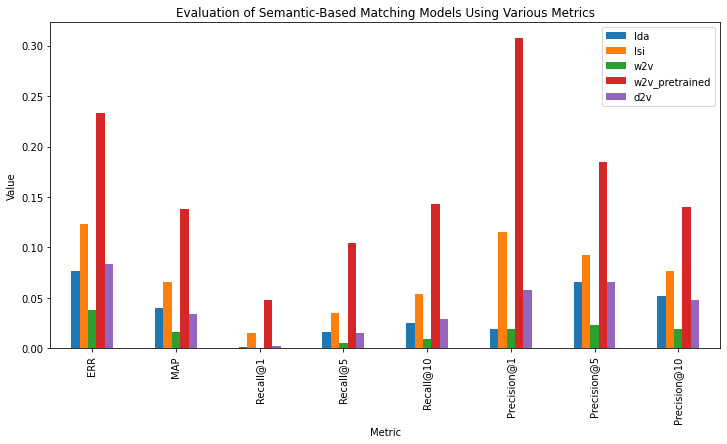

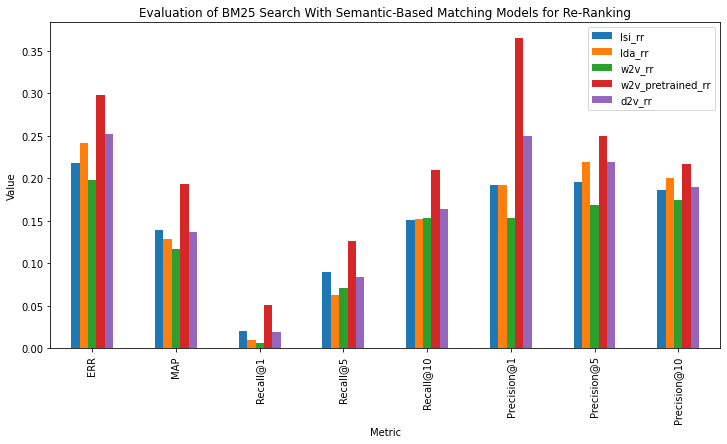

In [102]:
plot_results([s for s in list_of_sem_search_fns if "rr" not in s[0]],
             "Evaluation of Semantic-Based Matching Models Using Various Metrics", False)

plot_results([s for s in list_of_sem_search_fns if "rr" in s[0]],
             "Evaluation of BM25 Search With Semantic-Based Matching Models for Re-Ranking", False)

### Section 10.2: Summary (20 points)

Your summary should compare methods from Part 1 and Part 2 (only for index set 2). State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations. Consider the availability of data, scalability, domain/type of data, etc.

In this summary, we first compare the results of the plain semantic-based matching models (SBMMs) to each other. Then, we compare the results of the BM25 search function, reranked by the semantic-based matching models.

We observe that the pre-trained Word2Vec model performs significantly better than all the other models. This may be due to the large amount of data that this model is trained on. The trained Word2Vec model, trained on our tiny dataset, is the poorest performer of all SBMMs. The disparity between the pretrained Word2Vec and the trained Word2Vec demonstrates the importance of good word embeddings. The LSI and LDA models perform similarly, while the Doc2Vec model performs slightly worse.

The results when using the SBMMs for reranking were surprising. We expected to see that the performance of using BM25 and then reranking using a good SBMM would improve performance on a vanilla BM25 search. However, reranking harmed performance in every case. We believe this may be due to the difference in granularity in the BM25 search vs the SBMMs used. BM25 search operates at the word level, while SBMMs operate at the document level. Therefore, for an SBMM to improve performance on a vanilla BM25 search, it needs to be trained on a large amount of data to be expressive enough to represent an entire document or query accurately.

Admittedly, the pre-trained Word2Vec model is trained on a large amount of data. However, we used a relatively simple aggregation method of averaging each word in a document/query. Therefore, we are trying to match the "average word" in a query to the "average word" in a document. This method is vulnerable to words significantly different from the rest of the words in a sentence and can therefore return incorrect results. To improve the results using a pre-trained Word2Vec model, it would be interesting to investigate a more sophisticated aggregation function in future.